# 贝叶斯优化（Bayesian Optimization) with python
## 用python从无到有构建贝叶斯优化

主要参考：https://machinelearningmastery.com/what-is-bayesian-optimization/


In [1]:
import numpy as np
from numpy.random import random
from numpy.random import normal
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter

%matplotlib inline

在BO中有三个重要的部分：

1）objective function,一般是一个黑盒子，或者是计算较昂贵的计算模拟（如 分子模拟，量子模拟，分子对接等）； 

2）surrogate function/model,代理模型，用一个较便宜的模型来代替objective function。在BO中我们想要它来给采样函数提供信息；  

3）acquisition function,采样函数，决定在一次循环中采集哪一个/哪一些点来喂给objective function去评估；  


首先构建一个objective function,一般我们是不知道这个函数的具体形式的。现在为了演示的原因，我们构建这样一个简单的函数，
同时为了让这个函数更加难以拟合，我们给它加上一些噪音。

In [4]:
# objective function
def objective(x, noise=0.1):
	noise = np.random.normal(loc=0, scale=noise,size=x.shape)
	return (x**2 * np.sin(5 * np.pi * x)**6.0) + noise

我们先来看看这个函数长什么样子

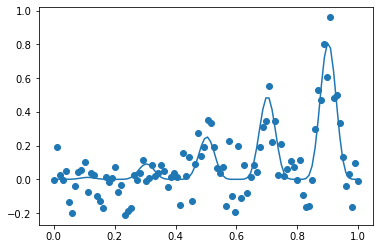

In [5]:
X = np.linspace(0,1,100)
y = objective(X,noise=0.1)
y_0 = objective(X,noise=0)
plt.scatter(X,y)
plt.plot(X,y_0)
X = X.reshape((len(X),1))
y = y.reshape((len(y),1))

构建代理函数

In [6]:
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [7]:
model = GaussianProcessRegressor() # 选用GP模型，实例化

In [8]:
model.fit(X,y) #初始化模型

GaussianProcessRegressor()

我们先来看看初始化的模型长什么样子

In [9]:
X_Samples = np.arange(0,1,0.01)
X_Samples = X_Samples.reshape(len(X_Samples),1)
y_samples,_ = surrogate(model,X_Samples)

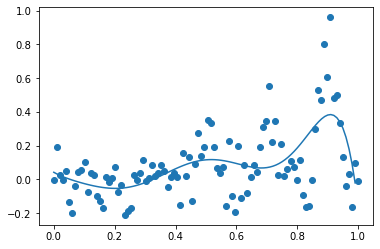

In [10]:
plt.scatter(X,y)
plt.plot(X_Samples,y_samples)

我们选用probability of improvement acquisition function PI = cdf((mu – best_mu) / stdev)

一个很好的介绍acquisition functions 的博客：https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html

In [11]:
# probability of improvement acquisition function
def acquisition(X, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return (Xsamples[probs.argmax()][0],probs) #返回概率最好的取样点


0.9080931240365007

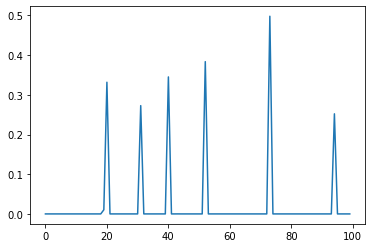

In [12]:
smapled_X,probs = acquisition(X,model)
plt.plot(probs)
smapled_X

开始BO迭代

In [15]:
added_X = []
added_y = []
# perform the optimization process
for _ in range(100):
    # select the next point to sample
    x,_ = acquisition(X, model)
    # sample the point
    actual = objective(x)
    added_X.append(x)
    added_y.append(actual)
    # add the data to the dataset
    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

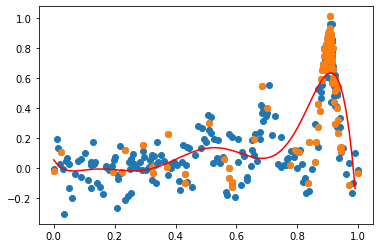

In [20]:
y_samples,_ = surrogate(model,X_Samples)
plt.plot(X_Samples,y_samples,c='r')
plt.scatter(X,y)
plt.scatter(added_X,added_y) #plot added points

其中橙色的点是在BO迭代中acquisition采样新增的点，可以看到在函数最大值附近富集了更多的点。这个是符合我们的预期的。